<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Classification_Recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- UNDER CONSTRUCTION! ---

# TO DO
* GNB?  Guess I don't need to grid search...  Show how to use pipe w.o grid
* Linear models?  At least SVM
* Include some sample reports like classification report and confusion matrix

**Dr. Daugherity, PHYS 453, Spring 2024**

# Classification Recipe
This notebook will give you basic outline for classification using best practices and more advanced tools from sklearn.    

## Workflow - The Order Is Important!

These are the steps:
1.  **Load Data** - I really mention this as a step because in real-world problems you are likely to spend >80% of your time collecting, reading, exploring, and cleaning data.  
1.  **Test/Train Split** - The first thing you do after getting data is to hide away a portion as your final test set.  Any data that has been *fit* cannot be used for a fair evaluation of the classifier's performance on new data.  Even something as simple as feature scaling can bias results.  
1.  **Pipeline** - Set up all data transforms and your classifier in a pipeline and use it exclusively to access data.  
  1.  **Transforms** - All of the data preprocessing steps such as scaling (which you should nearly always do) and feature engineering
  1.  **Estimator** - The final step in the pipeline is our classifier (or regressor).  The pipeline automatically applies all of the transforms every time we use it.
1.  **Grid Search** - Tune all of the parameters with a cross-validation grid search.  Check for signs of under-fitting and over-fitting by comparing the training and validation scores.
1.  **Final Test** - Only after you are completely done training your model, then you may run it on the saved test set to measure performance on new data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Data Set
In most machine learning problems with real-world data you can expect to spend >80% of your time on the project just dealing with the data sets.  I'm not going to cover cleaning and feature engineering here, but here are some issues to consider.

See Tutorial 10 for some more examples of all of these steps.

## Loading Data  
See the data loading utilities in the User's Guide here: https://scikit-learn.org/stable/datasets.html.  Common options:
* Pandas:  [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [read_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html), etc.  More options [here](https://pandas.pydata.org/pandas-docs/stable/reference/io.html)
* openml repository: [sklearn.datasets.fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html#sklearn.datasets.fetch_openml)
* Generated: use [sklearn generators](https://scikit-learn.org/stable/datasets/sample_generators.html) to follow my Golden Rule of Computing you should play with some data where you know the right answer  

In this notebook I'll assume we are starting with a Pandas dataframe.


## Cleaning Data
* Missing Data:
  * Pandas tools like [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) and [dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna).  See [Working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) for more
  * sklearn can [impute missing values](https://scikit-learn.org/stable/modules/impute.html#impute) using tools like [SimpleInputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

* Making Numerical Features:
  * sklearn can [encode categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) and [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
  * pandas similar functions are [factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html#pandas.factorize) and   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), see more [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#reshaping-dummies)
  * sklearn also has special tools for extracting features from [text](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) and [images](https://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction)  

## Plotting Data
Make sure you understand the data you've got.  If you don't have too many features, it can be helpful to [make plots](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html). This step is sometimes called expolatory data analysis (EDA).




## Load Dataframe
A quick example of loading and exploring a pandas dataframe.

In [2]:
iris_data = datasets.load_iris(as_frame=True)

In [3]:
df = iris_data['frame']
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## Check Dataframe

In [4]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
df.dtypes  # check for non-numeric columns

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                 int64
dtype: object

In [6]:
print('Number of NaN/null values:')
pd.isna(df).sum()

Number of NaN/null values:


sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

This dataset is pre-cleaned.  Everything is numeric and there are no missing values, so we can proceed.

## Convert to numpy
As of now, most of sklearn's classes can accept either numpy arrays or dataframes as input, so this step may not be necessary.   

In [7]:
y = df['target'].to_numpy()

In [8]:
# Here's two ways to select which columns we want
# OPTION 1:
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']  # copied-and-pasted from df.columns
X = df[features].to_numpy()

# OPTION 2: ILOC
X = df.iloc[:,0:4].to_numpy() # select columns 0-3

# Preprocess Data
Prepare the data for the classifier.



## Test/Train Split
Now we split data intro train and test subsets.  **IT IS IMPORTANT TO DO THIS FIRST** before any other operations take place.  I recommend reading through the [common pitfalls](https://scikit-learn.org/stable/common_pitfalls.html) for more insights and discussion.
* only call fit on X_train
* only use X_test to evaulate the final accuracy

Use `stratify=y` to ensure proportional numbers of each target go to each set.

One important clarification: when we tell GridSearchCV to fit X_train, it tunes parameters by further splitting X_train into pieces to make training and [validation](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) sets.  When we look at GridSearchCV "*test*" scores we are actually looking at portion of X_train, so it is best to call this the validation set.  We never let grid search see X_test until the final evaluation.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2,stratify=y)

In [10]:
print('Train\t',X_train.shape)
print('Test\t',X_test.shape)

Train	 (120, 4)
Test	 (30, 4)


# Helper Functions
Define helper functions for plotting grid search results:
* ```plot_2par_grid_search``` makes a lovely plot but only works for 2 parameters
* ```make_grid_plot``` is a little messier but works for any number of parameters

In [11]:
# These functions visualize results from a parameter grid search.

def make_grid_plot_labels(grid_clf):
  # Turns a parameter dictionary entry into a single string.  Not elegant.
  res = grid_clf.cv_results_
  NUM_KEYS = len(res['params'][0].values())
  labels = []
  for item in res['params']:
    s = ""
    for val in item.values():
      s+= str(val)
      s+='_'
    labels.append(s[:-1])
  return labels

def make_grid_plot(grid_clf):
  # Displays the scores for every set of parameters
  res = grid_clf.cv_results_
  plt.figure(figsize=(8,4))
  plt.axvline(grid_clf.best_index_, color='black', lw=2) # draw black line behind best params
  plt.plot(res['mean_test_score'],'-o', label='Val')
  plt.plot(res['mean_train_score'],'-s', label='Train')
  plt.title('Grid CV Results')
  plt.ylabel('Mean Test Score')
  NUM_KEYS = len(res['params'])
  labels = make_grid_plot_labels(grid_clf)
  plt.xticks(ticks = np.arange(NUM_KEYS), labels=labels, rotation=90)
  plt.legend()
  plt.grid()
  plt.show()

def plot_2par_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,show_train=1):
  """Plot GridCV results for two parameter searches"""
  # from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv with a fixed bug
  val_scores = np.array(cv_results['mean_test_score']).reshape(len(grid_param_1),len(grid_param_2)) # FIXED A BUG HERE
  train_scores = np.array(cv_results['mean_train_score']).reshape(len(grid_param_1),len(grid_param_2))

  _, ax = plt.subplots(1,1,figsize=(10,4))
  cmap = plt.get_cmap("tab10")

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2):
    ax.plot(grid_param_1, val_scores[:,idx], '-o',  color=cmap(idx), label=f"Val:   {name_param_2}={str(val)}") # FIXED
    if show_train: ax.plot(grid_param_1, train_scores[:,idx], ':.', color=cmap(idx), label=f"Train: {name_param_2}={str(val)}")

  ax.set_title("Grid Search Scores")
  ax.set_xlabel(name_param_1)
  ax.set_ylabel('CV Average Score')
  ax.legend(loc='upper right')
  ax.grid('on')

## Pipeline
The next steps will happen inside a [pipeline](https://scikit-learn.org/stable/modules/compose.html).  We need to scale the data (and possibly transform it in other exciting ways), and setting up a pipeline ensures that we will treat the test and train sets exactly the same way. See a simple example of pipeline usage [here](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py).



Remember that it is vital (for most classifiers) to scale the data first.  The other steps are optional and problem-specific.
* (required) Scaling: use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler), or [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler);  see the [User's Guide here](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
* (optional): other transforms like dimensionality reduction using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

The last step in the pipeline will be the classifier. It is easier to make the pipeline all at once, so we'll do the pipeline code along with the classifiers below.




# Train

In [12]:
scores = dict()  # set up a variable to store the final scores

## Nearest Neighbors

**References**
* User Guide: http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors
* API: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


**Parameters to know**
* ```n_neighbors```: also known as *k*, the number of neighbors. Default is 5
* ```weights```={‘uniform’, ‘distance’}: distance probably works better, but it is annoying that the validation score is always 1

**Training Notes**
* k=1 overfits while large values of k (close to N) underfits
* The training score is also always 1 for k=1 (unless there is a tie) or for distance weights
* Start with k=1 and increase to a large enough value that you see a peak in the validation scores
* You can try both options for ```weights``` or just use distance




Grid Parameters: {'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'clf__weights': ['uniform', 'distance']}
Best parameters: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Best Validation Score:	0.950


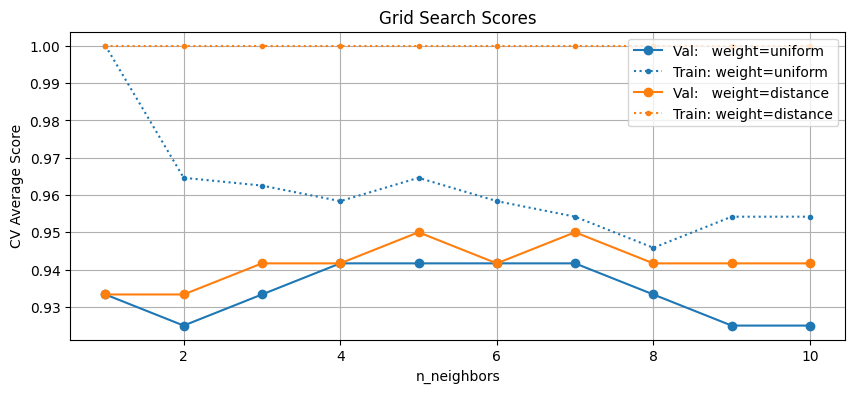

In [13]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,11)
WLIST = ['uniform','distance']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")  #


plot_2par_grid_search(grid_clf.cv_results_, KLIST, WLIST, 'n_neighbors', 'weight')  # only works for 2 parameters

#scores['KNeighbors'] = grid_clf.score(X_test,y_test)
scores['KNeighbors'] = grid_clf.best_score_

## Decision Tree

**References**
* User Guide: https://scikit-learn.org/stable/modules/tree.html#tree
* API: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


**Parameters to know**
* ```max_depth```: Tree grows until the training score is 1 or max_depth is reached.  Default is *none* which will overfit.

**Training Notes**
* Increase max_depth until the train score is 1.00, this is the tree's true maximum depth and there is no point in going any higher
* In event of a tie when choosing features for the next split it will make a random choice.  Set `random_state` if you want consistent behavior
* The tree's performance is not affected by scaling the data.  If you want to make tree plots later, then you can just use **UN**scaled data for the tree.



Grid Parameters: {'clf__max_depth': array([1, 2, 3, 4, 5, 6, 7])}
Best parameters: {'clf__max_depth': 2}
Best Train Score:	0.958


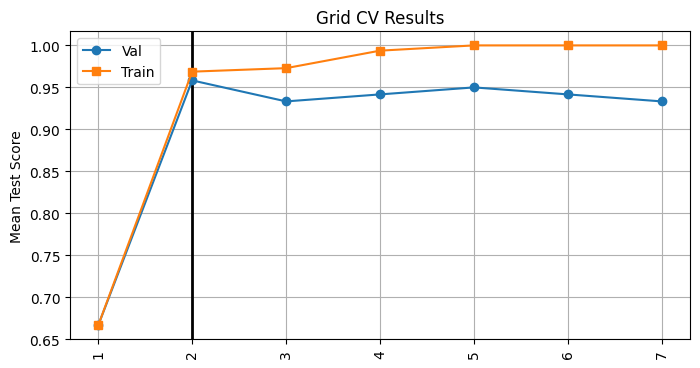

In [14]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', DecisionTreeClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
DEPTHS = np.arange(1,8)
params = {'clf__max_depth':DEPTHS}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf) # Plot the results

scores['DecisionTree'] = grid_clf.best_score_

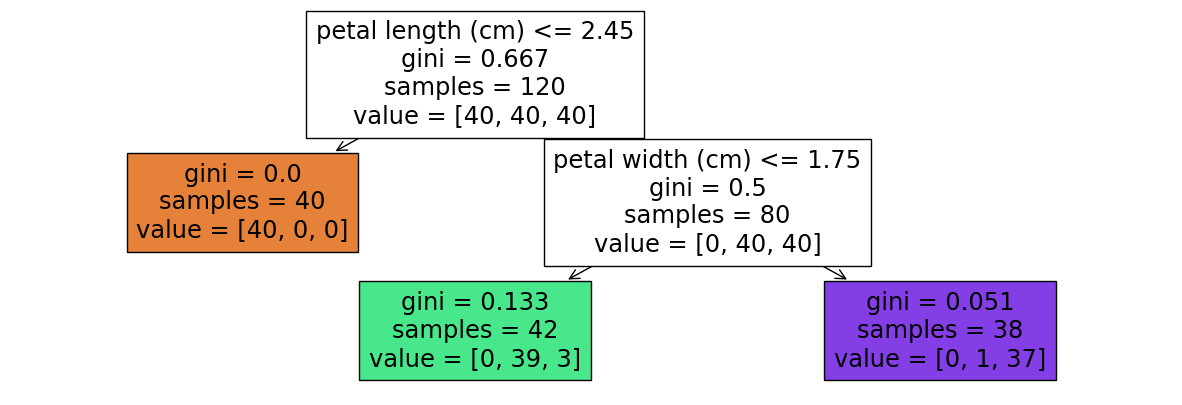

In [15]:
# To train a new unscaled tree you can use this:
clf = DecisionTreeClassifier(max_depth = grid_clf.best_params_['clf__max_depth'])
clf.fit(X_train,y_train)

plt.figure(figsize=(15,5))
plot_tree(clf, filled=True, feature_names=features)
plt.show()

## Gradient Boosted Trees
In sklearn we get two implementations:
1.  **GradientBoostingClassifier** is a bit more accurate (especially for small number of data samples) but slower
1.  **HistGradientBoostingClassifier** is orders of magnitude faster and has built-in support for missing values, but a tiny bit less accurate.  


They are similar but annoyingly different to use.
I'll only use the fast HistGBC here.  (If you want to use the other one see my tutorial for details on the parameters)


**References**
* Users Guide: https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees
* HGBC API: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html

**Parameters to Know**
* ```max_iter```=100, main parameter, fairly robust to overfitting so a "large number" usually gives better performance
* ```learning_rate``` = 0.1, trade-off between learning_rate and n_estimators.  Each new learner is scaled by learning_rate, so smaller rate needs more learners
* ```early_stopping```='auto', auto enables early stopping when sample size>10k
* ```n_iter_no_change```=10: only used when early stopping
* ```validation_fraction```=0.1, only used if early_stopping
* ```tol```=1e-7: only used if early_stopping

**Training Notes**
The recommended approach is easy:
* ```learning_rate```=0.1 (this is the default)
* enable early stopping
* add enough trees so that early stopping happens
* no grid search needed (but still use pipeline and scalar)


In [25]:
# Define Pipeline
estimators = [('scaler', StandardScaler()),
 ('clf', HistGradientBoostingClassifier(max_iter=200, early_stopping=True, verbose=0, random_state=0)) ]
pipe = Pipeline(estimators)

pipe.fit(X_train,y_train)
print('n_estimators asked: ', pipe[-1].max_iter)
print('n_estimators used:  ', pipe[-1].n_iter_)
print('Train Score: ',pipe.score(X_train,y_train))

scores['Hist GB Tree'] = grid_clf.best_score_

n_estimators asked:  200
n_estimators used:   31
Train Score:  0.9833333333333333


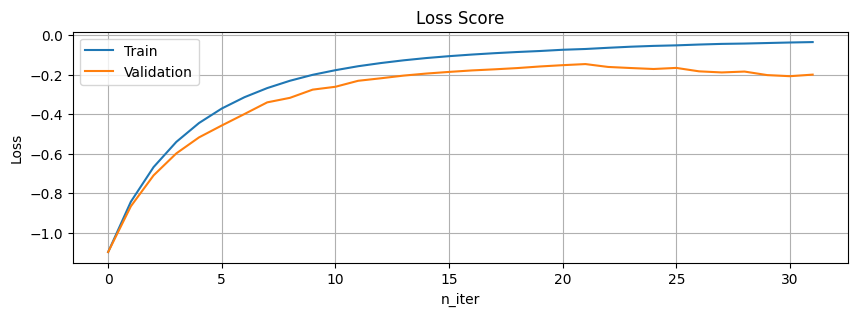

In [19]:
plt.figure(figsize=(10,3))
plt.plot(pipe[-1].train_score_,label='Train')
plt.plot(pipe[-1].validation_score_,label='Validation')
plt.legend()
plt.title('Loss Score')
plt.xlabel('n_iter')
plt.ylabel('Loss')
plt.grid()
plt.show()

##Support Vector Machines

Works by ignoring every data point except those near the boundary (aka the 'support vectors') and tries to maximize the distance.  Can use the kernel trick to add non-linear features to a linear classifier.

**References**
* User Guide: https://scikit-learn.org/stable/modules/svm.html
* API: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

**Parameters to know**
* ```kernel```: Default is 'rbf', options are ['linear', 'poly', 'rbf', 'sigmoid'].  
* ```degree```=3, only used for poly kernel
* ```C```=1.0, L2 regularization parameter

**Training Notes**
* If the dataset is very large consider switching to LinearSVC for faster performance




In [27]:
from sklearn.svm import SVC

Grid Parameters: {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
Best parameters: {'clf__kernel': 'linear'}
Best Train Score:	0.967


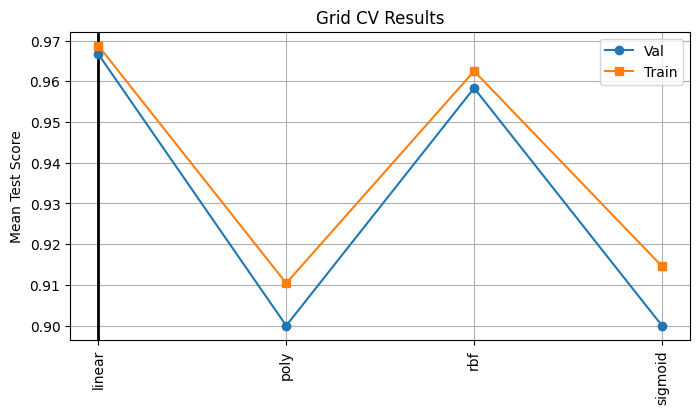

In [30]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', SVC()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
params = {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf) # Plot the results

scores['NeuralNetwork'] = grid_clf.best_score_

## Neural Network

References:
* User's Guide - http://scikit-learn.org/stable/modules/neural_networks_supervised.html
* API - http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

Notes:
* Each run starts with **random** weights.  Remove random_state if you want different results every time
* Ideally you will have 5-10 training samples per weight.  So for a single hidden layer the number of features times the number of hidden nodes should not exceed 20% of the number of training samples.  Here we have 4 features and 120 samples,  so we can't expect reliable results for much more than 20 nodes
* Adding parameter options makes the grid search **EXPONENTIALLY** longer.  Start with just hidden nodes to narrow down a range, then add activation function or others
* To suppress warnings add this code above the grid search (make sure to indent):
```
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
```



Grid Parameters: {'clf__hidden_layer_sizes': [4, 6, 8, 10, (2, 2), (3, 3), (4, 4)]}
Best parameters: {'clf__hidden_layer_sizes': (3, 3)}
Best Train Score:	0.975


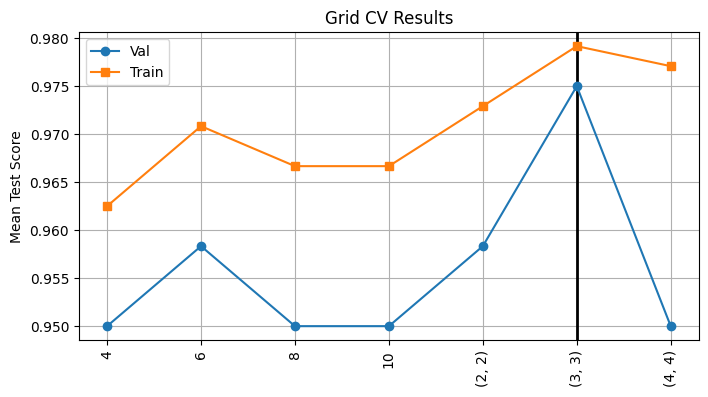

In [16]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', MLPClassifier(max_iter=2000, random_state=0)) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
#params = {'clf__hidden_layer_sizes': np.arange(2,10)}   # start with something like this for single layer
params = {'clf__hidden_layer_sizes': [(4),(6),(8),(10),(2,2),(3,3),(4,4)]}   # 2 layer example
#params = {'clf__hidden_layer_sizes': [(5),(10),(3,3),(4,4)],  'clf__activation': ['tanh', 'relu'] } # varying activation functions
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")

make_grid_plot(grid_clf) # Plot the results

scores['NeuralNetwork'] = grid_clf.best_score_

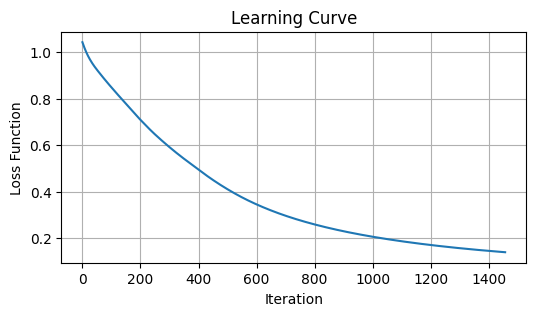

In [17]:
plt.figure(figsize=(6,3))
clf = grid_clf.best_estimator_[-1]
plt.plot(clf.loss_curve_)
plt.ylabel('Loss Function')
plt.xlabel('Iteration')
plt.title('Learning Curve')
plt.grid()
plt.show()

# Final Summary

In [26]:
print('Test Scores:')
for k,v in scores.items():
  print(f"{k}\t{v:0.3f}")

Test Scores:
KNeighbors	0.950
DecisionTree	0.958
NeuralNetwork	0.975
GBT	0.975
HistGBT	0.975
Hist GB Tree	0.975


# Evaluate
**NOTES**

* Do not run this code until you are done training your model
* Don't have data leakage.  Do not go back and adjust options to improve test scores

In [21]:
# Only run this one time after you are completely done
print(f"Grid Test SCORE:\t{grid_clf.score(X_test,y_test):0.3f}")

Grid Test SCORE:	1.000
